# TM10007 Assignment Head and Neck cancer Radiomics

Marie-Claire Doornbos ()
Julia Holdorp (4561651)
Quinten Mank (4336615)
Ylva Weeda ()

 

In [4]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [8]:
## Importing Modules

In [67]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, accuracy_score, confusion_matrix
from scipy import interp


## 1. Data loading


In [ ]:
# Load data
from hn.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

if data.isnull().values.any():
    print('In the csv data file, some values are missing or NaN'), sys.exit


In [4]:
""" Extract feature values and labels """
# Features
features = data.loc[:, data.columns != 'label'].values
features = StandardScaler().fit_transform(features)

# Labels
labels = data.loc[:,['label']].values
labels = [item if item!='T12' else 0 for item in labels]
labels = [item if item!='T34' else 1 for item in labels]
labels = np.array(labels)
print(f'Number of high risk patients: {np.count_nonzero(labels)}') 
print(f'Number of low risk patients: {len(labels) - np.count_nonzero(labels)}')

Number of high risk patients: 55
Number of low risk patients: 58


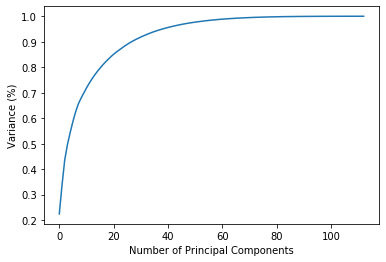

## 2. Preprocessing 
The data is split into feature values and labels (high risk or low risk). The amount of high-risk and low-risk patients is printed as an output. 
To optimize the machine learning algorithm, the features of the dataset are normalized using StandardScaler.
If the dataset contains any missing values or NaN, an error is printed and the algorithm stops.

- Handling missing data
- Implementing standard scalar on the data


In [5]:
# 3. Feature selection


In [40]:
# Hier moet feature selection komen, weet alleen nog niet helemaal hoe...

In [86]:
# Splitting the data in a training and a test set 
def split_sets(features, labels):
    """
    Splits the features and labels into a training set (80%) and test set (20%)
    """
    x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=1)
    return x_train, x_test, y_train, y_test 

x_train, x_test, y_train, y_test = split_sets(features, labels) 

# The training set is again divided into a training and a validation set and afterwards classified using a leave one out validation and logistic regression.

def leave_one_out_val(x,y):
    """
    Leave One Out Cross Validation using Logistic Regression as a classifier
    """
    loo = LeaveOneOut()
    loo.get_n_splits(x,y)

    predict_labels = [] 
    predict_proba =[]
    y_val_total = []

    for train_index, val_index in loo.split(x,y):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val= y[train_index], y[val_index]

        if min(x_train.shape[0], x_train.shape[1]) < 70:
            print('Not enough input values for PCA with 70 components')
            sys.exit()
        else:
            pca = PCA(n_components=70)
            pca.fit(x_train)
            x_train = pca.transform(x_train)
            x_val = pca.transform(x_val)

            lrg= LogisticRegression()
            lrg.fit(x_train,y_train) 
    
            lrg_predicted=lrg.predict(x_val)
            predict_labels.append(lrg_predicted)
            predict = lrg.predict_proba(x_val)[:,1]
            predict_proba.append(predict)
            y_val_total.append(y_val)
    predict_labels = np.array(predict_labels)
    predic_proba = np.array(predict_proba)

    return predict_labels, predict_proba, y_val_total

predict_labels_loo, predict_proba_loo, y_val_total_loo = leave_one_out_val(x_train,y_train)

# The training set is again divided into a training and a validation set and afterwards classified using a Kfold cross validation and logistic regression.
def cross_val(x,y):
    """
    Cross validation using a Logistic Regression classifier (5 folds)
    """

    crss_val = RepeatedKFold(n_splits = 5, n_repeats=10, random_state = None)           
    crss_val.get_n_splits(x, y)

    idx = np.arange(0, len(y))

    predict_labels = []
    predict_probas = []
    y_val_total = [] 

    for i, (train_index, val_index) in enumerate(crss_val.split(x, y)):
        x_train, x_val = x[idx][train_index], x[idx][val_index]
        y_train, y_val= y[idx][train_index], y[idx][val_index]

        if min(x_train.shape[0], x_train.shape[1]) < 70:
            print('Not enough input values for PCA with 70 components')
            sys.exit()
        else:
            pca = PCA(n_components=70)
            pca.fit(x_train)
            x_train = pca.transform(x_train)
            x_val = pca.transform(x_val)

            lrg=LogisticRegression()
            lrg.fit(x_train,y_train) 
            prediction=lrg.predict(x_val)
            predict_labels.append(prediction)
            predict = lrg.predict_proba(x_val)[:,1]
            predict_probas.append(predict)
            y_val_total.append(y_val)
   
    return predict_labels, predict_probas, y_val_total

predict_labels_crss, predict_proba_crss, y_val_total_crss = cross_val(x_train, y_train)


## 6. Evaluation
To evaluate the machine learning algoritm for the prediction of the T-score in head and neck cancer patients, different outcome measures are used. The area under the ROC curve is plotted and also accuracy, sensitivity and specificity are computed using the confusion matrix. 

--> box plots


In [77]:
def plot_roc(y_test, y_score, n_components):
    """
    Plots ROC curves
    Function returns none
    """
    try:
        # Make dictionaries
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(1):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Create plots
        plt.figure()
        lw_ = 1
        plt.plot(fpr[0], tpr[0], color='darkorange',
                 lw=lw_, label='ROC curve (area = %0.2f)' % roc_auc[0])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw_, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver operating characteristic, {n_components}\
                  principle components')
        plt.legend(loc="lower right")
        plt.show(block=False)

        # Catch an unexpected error
    except Exception as error:
        print('Unexpected error:'+str(error))
        raise
    return None


def compute_performance(labels_test, predict_test):
    """
    Compute accuracy, sensitivity and specificity based on confusion matrix.
    """
    try:
        # Form confusion matrix
        conf_matrix = confusion_matrix(labels_test, predict_test).ravel()

        # Calculate accuracy
        accuracy = (conf_matrix[0]+conf_matrix[3])/(conf_matrix[0] +
                                                    conf_matrix[1] + conf_matrix[2]
                                                    + conf_matrix[3])
        # Calculate sensitivity
        sensitivity = conf_matrix[3]/(conf_matrix[3]+conf_matrix[2])

        # Calculate specificity
        specificity = conf_matrix[0]/(conf_matrix[0]
                                      +conf_matrix[1])

    except Exception as error:
        print("Unexpected error:"+str(error))
        raise
    
    return(accuracy, sensitivity, specificity)



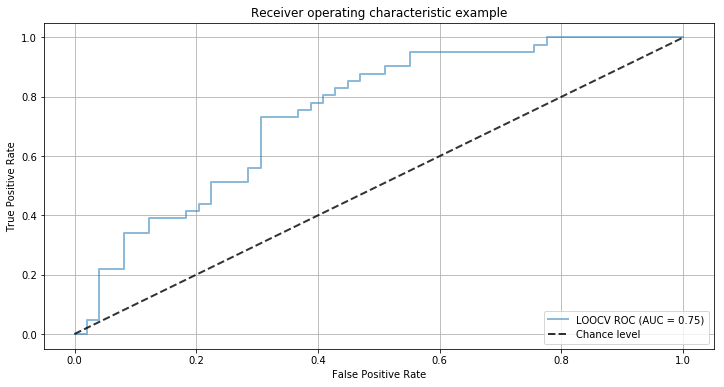

In [78]:
# ROC plot for leave one out cross validation 
def plot_roc_loo(y_val, predicted_probas):
    fpr, tpr, __ = roc_curve(y_val, predicted_probas)
    roc_auc = auc(fpr, tpr)
    plt.figure(1, figsize=(12,6))
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label='LOOCV ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

plot_roc_loo(y_val_total_loo, predict_proba_loo)

In [79]:
#accuracy, sensitivity and specificity printed
accuracy_loo, sensitivity_loo, specificity_loo = compute_performance(predict_labels, y_val_total_loo)

print(f'Accuracy = {accuracy_loo}')
print(f'Sensitivity = {sensitivity_loo}')
print(f'Specificity = {specificity_loo}')


Accuracy = 0.6444444444444445
Sensitivity = 0.6153846153846154
Specificity = 0.6666666666666666


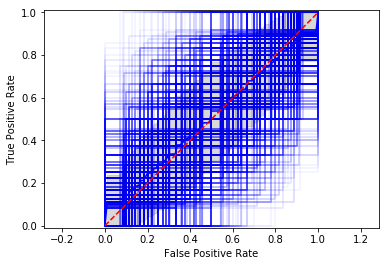

In [85]:
def plot_roc_crss(y_val, predicted_probas):
    tprs = []
    base_fpr = np.linspace(0, 1, 101)

    for fold in y_val:
        for prob in predicted_probas:
            fpr, tpr, _ = roc_curve(fold, prob)
            plt.plot(fpr, tpr, 'b', alpha=0.05)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
    
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std


    plt.plot(base_fpr, mean_tprs, 'b')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.axes().set_aspect('equal', 'datalim')
    plt.show()

plot_roc_crss(y_val_total_crss, predict_proba_crss)